In [4]:
import pandas as pd
import json
from dateutil.parser import parse  # Importing the parse function from dateutil.parser

# Function to read JSON data and convert to DataFrame
def json_to_dataframe(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        titles = []
        dates = []
        descriptions = []
        sources = []
        for article in data:
            titles.append(article.get('title', None))
            dates.append(article.get('dateModified', None))
            descriptions.append(article.get('articleBody', None))
            sources.append(article.get('source', None))
        df = pd.DataFrame({'title': titles, 'date': dates, 'description': descriptions, 'source': sources})
        df.drop_duplicates(subset=['title'], inplace=True)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

# Create DataFrame from JSON data
df = json_to_dataframe('data.json')

# Display the DataFrame
print(df)


                                                   title   
0      Shiv Sena MP Sanjay Raut Responds To 'Hamas' R...  \
1      Uddhav buried Bal Thackeray's 'Hindutva' for p...   
2      Israel biggest terrorist nation in the world, ...   
3      Eight Ex-Indian Navy Officers Get Death Penalt...   
4      Israel’s response to Hamas terrorist attack di...   
...                                                  ...   
21202  Jacob Zuma banned from running in South Africa...   
21203  The Fatah Fighters of Gaza – Resistance Roundu...   
21204  Israel Publishes Video of Islamic Jihad Terror...   
21205  United Nations secretary general condemns expl...   
21206  Raghav Chadha stirs a row as he meets this UK ...   

                                        date   
0      {'$date': '2023-10-25T06:35:50.000Z'}  \
1      {'$date': '2023-10-25T02:14:27.000Z'}   
2      {'$date': '2023-10-26T14:45:24.000Z'}   
3      {'$date': '2023-10-26T11:22:00.000Z'}   
4      {'$date': '2023-10-26T13:51:52.0

In [5]:
import spacy
from tqdm import tqdm

# Load spaCy model
nlp = spacy.load('en_core_web_md')

# Initialize variables
docs = []
sent_vecs = {}

# Iterate over titles in the DataFrame
for title in tqdm(df.title):
    # Process the title using spaCy
    doc = nlp(title)
    # Append the processed document to the list
    docs.append(doc)
    # Update the dictionary with title as key and its vector as value
    sent_vecs.update({title: doc.vector})

# Extract keys (titles) and values (vectors)
titles = list(sent_vecs.keys())
vectors = list(sent_vecs.values())


100%|██████████| 21207/21207 [04:41<00:00, 75.35it/s] 


In [6]:
import numpy as np
from sklearn.cluster import DBSCAN
from tqdm import tqdm

# Convert vectors to a numpy array
x = np.array(vectors)

# Initialize dictionary to store the number of clusters for each epsilon value
n_classes = {}

# Perform DBSCAN clustering for a range of epsilon values
for i in tqdm(np.arange(0.001, 1, 0.002)):
    dbscan = DBSCAN(eps=i, min_samples=2, metric='euclidean').fit(x)
    labels = dbscan.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_classes[i] = n_clusters
 
# Specific DBSCAN clustering with epsilon = 0.08
dbscan_specific = DBSCAN(eps=0.08, min_samples=2, metric='euclidean').fit(x)


100%|██████████| 500/500 [1:13:13<00:00,  8.79s/it] 


In [16]:

# Merge the clustering results with the original DataFrame
event_df = df.merge(results_df, on='title')

# Convert the 'date' column to datetime format
event_df['date'] = pd.to_datetime(event_df['date'].apply(lambda x: x['$date'] if isinstance(x, dict) else x))

# Set display options to show full content of 'title' column
pd.set_option('display.max_colwidth', None)

# Select only the 'date' and 'title' columns
event_df_subset = event_df[['date', 'title']]

# Display the resulting DataFrame
print(event_df_subset)


                           date   
0     2023-10-25 06:35:50+00:00  \
1     2023-10-25 02:14:27+00:00   
2     2023-10-26 14:45:24+00:00   
3     2023-10-26 11:22:00+00:00   
4     2023-10-26 13:51:52+00:00   
...                         ...   
21202 2024-03-30 06:37:44+00:00   
21203 2024-03-30 22:20:29+00:00   
21204 2024-03-28 00:00:00+00:00   
21205 2024-03-31 00:00:00+00:00   
21206 2024-03-26 16:01:17+00:00   

                                                                                                   title  
0                                  Shiv Sena MP Sanjay Raut Responds To 'Hamas' Remark In Fiery Exchange  
1                      Uddhav buried Bal Thackeray's 'Hindutva' for power; may hug Hamas one day: Shinde  
2                                    Israel biggest terrorist nation in the world, says Sadikali Thangal  
3                   Eight Ex-Indian Navy Officers Get Death Penalty In Qatar; India To Challenge Verdict  
4                      Israel’s response to 

In [20]:
import time

# Start the timer
start_time = time.time()

# Assuming you have already created the DataFrame 'event_df' with the necessary columns: 'date' and 'title'

# Sort the DataFrame by the 'date' column
event_df_sorted = event_df.sort_values(by='date')

# Filter the DataFrame to keep only one article per day
event_df_filtered = event_df_sorted.groupby(event_df_sorted['date'].dt.date).first().reset_index(drop=True)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

# Display the resulting DataFrame
print(event_df_filtered[['date', 'title']])


Elapsed time: 0.07600140571594238 seconds
                         date   
0   2014-01-10 23:29:29+00:00  \
1   2014-09-10 08:37:44+00:00   
2   2016-06-29 10:59:20+00:00   
3   2019-06-12 00:00:00+00:00   
4   2021-10-20 00:00:00+00:00   
..                        ...   
125 2024-03-30 00:00:00+00:00   
126 2024-03-31 00:00:00+00:00   
127 2024-12-19 00:00:00+00:00   
128 2024-12-25 00:00:00+00:00   
129 2028-02-20 00:00:00+00:00   

                                                                                      title  
0             Saleem Jaffar expects women's team to take the winning momentum in ODI series  
1         Factory worker killed by rocket strike in northern Israel, emergency services say  
2    Bikini islanders still deal with fallout of US nuclear tests, more than 70 years later  
3        Russian President Vladimir Putin To Visit Gulf Countries For First Time Since 2019  
4                          Car Collides With US President Joe Biden’s Motorcade In Delaware

In [23]:
import pandas as pd
import time

# Start the timer
start_time = time.time()

# Assuming you have already created the DataFrame 'event_df' with the necessary columns: 'date' and 'title'

# Sort the DataFrame by the 'date' column
event_df_sorted = event_df.sort_values(by='date')

# Filter the DataFrame to keep only one article per day
event_df_filtered = event_df_sorted.groupby(event_df_sorted['date'].dt.date).first().reset_index(drop=True)

# Extract only the date component from the 'date' column
event_df_filtered['date'] = event_df_filtered['date'].dt.date

# Concatenate 'date' and 'title' columns side by side
date_title_df = pd.concat([event_df_filtered['date'], event_df_filtered['title']], axis=1)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

# Display the resulting DataFrame
print(date_title_df)


Elapsed time: 0.0572361946105957 seconds
           date   
0    2014-01-10  \
1    2014-09-10   
2    2016-06-29   
3    2019-06-12   
4    2021-10-20   
..          ...   
125  2024-03-30   
126  2024-03-31   
127  2024-12-19   
128  2024-12-25   
129  2028-02-20   

                                                                                      title  
0             Saleem Jaffar expects women's team to take the winning momentum in ODI series  
1         Factory worker killed by rocket strike in northern Israel, emergency services say  
2    Bikini islanders still deal with fallout of US nuclear tests, more than 70 years later  
3        Russian President Vladimir Putin To Visit Gulf Countries For First Time Since 2019  
4                          Car Collides With US President Joe Biden’s Motorcade In Delaware  
..                                                                                      ...  
125                    Five killed in north Gaza amid gunfire and crush 

In [28]:
import time

# Start the timer
start_time = time.time()

# Assuming you have already created the DataFrame 'event_df' with the necessary columns: 'date' and 'title'

# Sort the DataFrame by the 'date' column
event_df_sorted = event_df.sort_values(by='date')

# Filter the DataFrame to keep only one article per day
event_df_filtered = event_df_sorted.groupby(event_df_sorted['date'].dt.date).first().reset_index(drop=True)

# Extract only the date component from the 'date' column
event_df_filtered['date'] = event_df_filtered['date'].dt.date

# Create a new DataFrame to store only titles related to Israel-Hamas conflict
filtered_df = event_df_filtered[event_df_filtered['title'].str.contains('Israel|Hamas', case=False)]

# Save the filtered DataFrame to a CSV file
filtered_df.to_csv('israel_hamas_titles.csv', index=False)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


Elapsed time: 2.5387308597564697 seconds


In [33]:
# Start the timer
start_time = time.time()

# Sample DataFrame (Replace this with your actual DataFrame)
event_df = pd.read_csv('israel_hamas_titles.csv')

# Function to extract timeline periods from titles
def extract_timeline_periods(df):
    timeline_periods = []
    current_period = None

    for index, row in df.iterrows():
        title = row['title']
        date = pd.to_datetime(row['date']).date()  # Extract only the date component
        
        # Check if the current title belongs to the same period
        if current_period:
            # If the date is consecutive, update the end date of the current period
            if date == current_period['end_date'] + pd.Timedelta(days=1):
                current_period['end_date'] = date
                current_period['titles'].append(title)
                continue
            # If the date is not consecutive, add the current period to the timeline periods list
            else:
                timeline_periods.append(current_period)

        # Start a new period
        current_period = {'start_date': date, 'end_date': date, 'titles': [title]}

    # Add the last period if it exists
    if current_period:
        timeline_periods.append(current_period)

    return timeline_periods

# Extract timeline periods
timeline_periods = extract_timeline_periods(event_df)

# Print the timeline periods
print("Timeline of Israel-Hamas Conflict Events:")
for period in timeline_periods:
    duration = f"{period['start_date']} - {period['end_date']}"
    titles = ', '.join(period['titles'])
    print(f"{duration}: {titles}")

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


Timeline of Israel-Hamas Conflict Events:
2014-09-10 - 2014-09-10: Factory worker killed by rocket strike in northern Israel, emergency services say
2023-01-12 - 2023-01-12: Israel shelling kills two in south Lebanon
2023-02-12 - 2023-02-12: Israeli war planes, artillery bombard southern Gaza
2023-02-20 - 2023-02-20: Israel Retrieves Bodies Of Two Abducted Soldiers
2023-07-12 - 2023-07-12: OIC Condemns the Israeli Occupation for Allowing Extremists to March into the Occupied City of Al-Quds and the Continued Israeli Aggression against the Palestinian People
2023-08-12 - 2023-08-12: OIC Condemns the Crime of the Israeli Occupation in Al-Far’a Camp and Calls on the UN Security Council to Assume its Responsibilities
2023-10-10 - 2023-10-10: Fragile Global Economy Faces New Crisis in Israel-Gaza War
2023-10-12 - 2023-10-12: Oil prices surge above $90 a barrel after Israel orders mass evacuations
2023-10-16 - 2023-10-17: Iranian FM says Hamas Attack a "Natural Reaction" of Palestinians, Liv

In [44]:
import pandas as pd
import time

# Sample DataFrame (Replace this with your actual DataFrame)
event_df = pd.read_csv('israel_hamas_titles.csv')

# Start the timer
start_time = time.time()

# Function to extract timeline periods from titles
def create_timeline(df):
    timeline = []
    current_period = None

    for index, row in df.iterrows():
        date = pd.to_datetime(row['date']).date()
        title = row['title']

        # Check if the title indicates the start of a new period
        if 'attack' in title.lower() or 'intensifies' in title.lower():
            if current_period:
                timeline.append(current_period)
            current_period = {'start_date': date, 'title': title}
        # Check if the title indicates the end of the current period
        elif 'ceasefire' in title.lower() or 'peace talks' in title.lower():
            if current_period:
                current_period['end_date'] = date - pd.Timedelta(days=1)
                timeline.append(current_period)
                current_period = None

    # Add the last period if it exists
    if current_period:
        timeline.append(current_period)

    return timeline

# Create the timeline
timeline = create_timeline(event_df)

# Print the timeline
print("Timeline:")
for i, period in enumerate(timeline):
    if i == len(timeline) - 1:
        print(f"{period['start_date']} - {period['title']}")
    else:
        next_period_start_date = timeline[i + 1]['start_date'] - pd.Timedelta(days=1)
        print(f"{period['start_date']} - {next_period_start_date}: {period['title']}")



Timeline:
2023-10-16 - 2023-10-21: Iranian FM says Hamas Attack a "Natural Reaction" of Palestinians
2023-10-22 - 2023-11-11: Israel attacks Hezbollah terror targets
2023-11-12 - 2023-11-19: Violence intensifies between Israel, Hezbollah
2023-11-20 - 2023-11-25: World Children’s Day tragedy: Gaza’s 5,500 lives lost to Israel’s attacks
2023-11-26 - 2023-12-03: Syria: Israel Attacks Damascus Airport, Military Base
2023-12-04 - 2023-12-09: Tourist from Boston killed in shark attack in Bahamas, police say
2023-12-10 - 2024-03-12: Islamic Jihad releases video depicting attacks on Israeli Forces
2024-03-13 - What Is Israel’s Goal in Lebanon? Increasing Cross-Border Attacks Risk Expanding the Gaza War


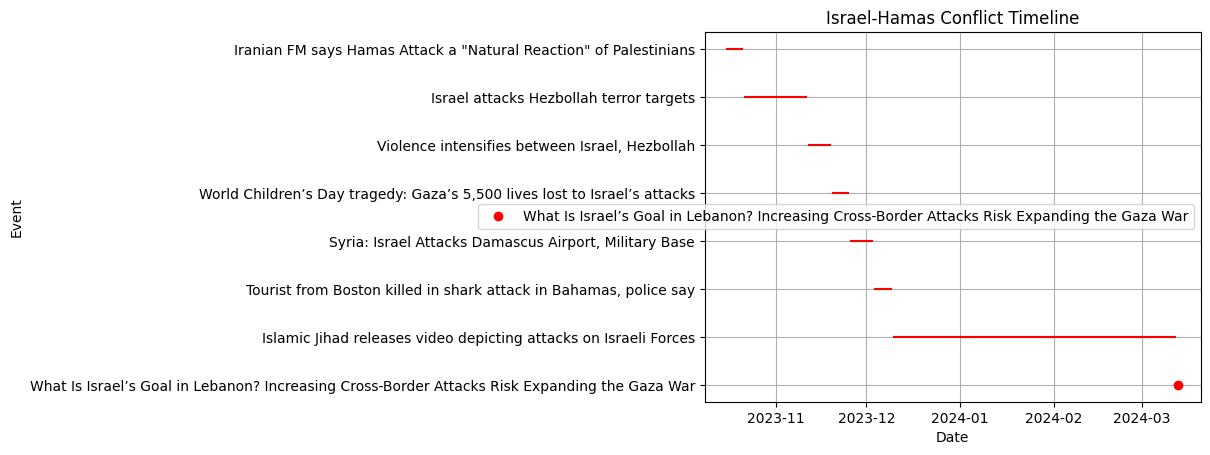

Elapsed time: 1.1290931701660156 seconds


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Sample DataFrame (Replace this with your actual DataFrame)
event_df = pd.read_csv('israel_hamas_titles.csv')

# Start the timer
start_time = time.time()

# Function to extract timeline periods from titles
def create_timeline(df):
    timeline = []
    current_period = None

    for index, row in df.iterrows():
        date = pd.to_datetime(row['date']).date()
        title = row['title']

        # Check if the title indicates the start of a new period
        if 'attack' in title.lower() or 'intensifies' in title.lower():
            if current_period:
                timeline.append(current_period)
            current_period = {'start_date': date, 'title': title}
        # Check if the title indicates the end of the current period
        elif 'ceasefire' in title.lower() or 'peace talks' in title.lower():
            if current_period:
                current_period['end_date'] = date - pd.Timedelta(days=1)
                timeline.append(current_period)
                current_period = None

    # Add the last period if it exists
    if current_period:
        timeline.append(current_period)

    return timeline

# Create the timeline
timeline = create_timeline(event_df)

# Function to plot the timeline
def plot_timeline(timeline):
    for i, period in enumerate(timeline):
        if i == len(timeline) - 1:
            plt.plot([period['start_date']], [i], 'ro', label=period['title'])
        else:
            next_period_start_date = timeline[i + 1]['start_date'] - pd.Timedelta(days=1)
            plt.plot([period['start_date'], next_period_start_date], [i, i], 'r-')

    plt.yticks(range(len(timeline)), [f"{period['title']}" for period in timeline])
    plt.xlabel('Date')
    plt.ylabel('Event')
    plt.title('Israel-Hamas Conflict Timeline')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the timeline
plot_timeline(timeline)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")
